In [1]:
import numpy as np


In [3]:
test = np.random.rand(100,2)

In [7]:
np.random.choice(test,size = (20,2))

ValueError: a must be 1-dimensional

In [4]:
test

array([[0.57329835, 0.19702566],
       [0.40691417, 0.67802231],
       [0.59196647, 0.4063508 ],
       [0.90814362, 0.76398211],
       [0.60374842, 0.16592974],
       [0.26176321, 0.841772  ],
       [0.14230232, 0.35731802],
       [0.21529653, 0.7287159 ],
       [0.62364111, 0.44421628],
       [0.93416552, 0.73867484],
       [0.63536797, 0.61718821],
       [0.3257065 , 0.51739598],
       [0.30891911, 0.06542563],
       [0.65385786, 0.60869661],
       [0.64333274, 0.43738455],
       [0.14241319, 0.33373118],
       [0.72242965, 0.84972309],
       [0.14200609, 0.0584162 ],
       [0.53350145, 0.59020866],
       [0.20863159, 0.34993143],
       [0.70188805, 0.67333968],
       [0.19420874, 0.87200187],
       [0.22457202, 0.57051165],
       [0.67815589, 0.64272351],
       [0.56972313, 0.10185782],
       [0.68198745, 0.51222829],
       [0.13568147, 0.43333645],
       [0.74380393, 0.76927469],
       [0.62881939, 0.62066244],
       [0.37415867, 0.66807315],
       [0.

In [1]:
from MOT import MOT
import numpy as np
import matplotlib.pyplot as plt
import os
from BfTableGenerator import RansacCollector
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
# from open3d import JVisualizer 
from Utils import *
from DDBSCAN import Raster_DBSCAN
import open3d as op3
# op3.visualization.webrtc_server.enable_webrtc()
from open3d.web_visualizer import draw
from VisulizerTools import *
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import multivariate_normal
from tqdm import tqdm_notebook
import time
from sklearn.cluster import DBSCAN


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [5]:
def get_thred_modified(ts,d ,thred_s ,N ,delta_thred ,step):# Ransac Para
    ts_temp = ts.copy()
    ts_temp[ts_temp == 0] = 1000
    valid_dises = []
    for i in range(N):
        sample = np.random.choice(ts_temp,replace=False)
        set_d = ts_temp[(ts_temp > sample - d)&(ts_temp < sample + d)]
        condition_thred = len(set_d)/len(ts_temp) > thred_s
        if condition_thred :
            valid_dises.append(sample)
            
    if len(valid_dises) == 0:
        return 1000

    cur_thred = np.min(valid_dises)

    while True:
        next_thred = cur_thred - step
        if (len(ts[ts > next_thred])/len(ts) - len(ts[ts > cur_thred])/len(ts)) < delta_thred:
            break
        cur_thred = next_thred

    return next_thred

In [42]:
def get_pcd_foreground(Td_map,Foreground_map):

    
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(Td_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = Td_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = Td_map[i] * np.sin(longitudes)
        Valid_ind = (Td_map[i] != 0) &(Foreground_map[i])
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Labeling_map[i][Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    
    pcd = op3.geometry.PointCloud()
    pcd.points = op3.utility.Vector3dVector(XYZ)
    return pcd  

In [2]:
collector_0 = RansacCollector(pcap_path=r'D:\LiDAR_Data\MidTown\California\2021-12-9-11-30-0.pcap',output_file_path='D:\LiDAR_Data\MidTown\California',update_frame_num=2000)
collector_0.gen_tdmap()

Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.41it/s]


In [3]:
threshold_map = np.load(r'D:\LiDAR_Data\MidTown\California\bck_map.npy')

In [53]:
clustering_db = DBSCAN(eps=0.2,min_samples=8)
Td_map = collector_0.aggregated_map[171]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_foreground(Td_map,Foreground_map)
X = np.asarray(pcd.points)[:,:2]
Labels = clustering_db.fit_predict(X)
Colors = np.full((len(Labels),3),np.array([[153,153,153]])/256)
unique_label = np.unique(Labels)
for l in unique_label[1:]:
    Colors[Labels == l] = color_map[l%len(color_map)]
pcd.colors = op3.utility.Vector3dVector(Colors)
draw(pcd,height=1000,width=1000)

In [7]:
clustering_td = Raster_DBSCAN(window_size=(5,13),eps = 1.2, min_samples= 8, Td_map_szie=threshold_map.shape)   
Td_map = collector_0.aggregated_map[171]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = clustering_td.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_3')

In [139]:
# %%timeit
d = 0.5
thred_s = 0.54
N = 20
delta_thred = 1e-3
step = 0.1
aggregated_maps_temp = collector_0.aggregated_map
threshold_map = np.zeros((32,1800))
print('Generating Threshold Map')
for i in range(32):
    for j in range(1800):
        t_s = aggregated_maps_temp[:,i,j].copy()
        threshold_value = get_thred_modified(t_s,d,thred_s,N,delta_thred,step)
        threshold_map[i,j] = threshold_value


Generating Threshold Map


In [8]:
np.save(r'D:\LiDAR_Data\MidTown\Liberty\test_thred_map.npy',threshold_map)

In [9]:
threshold_map = np.load(r'D:\LiDAR_Data\MidTown\Liberty\test_thred_map.npy')

In [124]:
aggregated_maps_temp = collector_0.aggregated_map

In [126]:
temp = aggregated_maps_temp[:2000,laser_id,azimuth_channel]

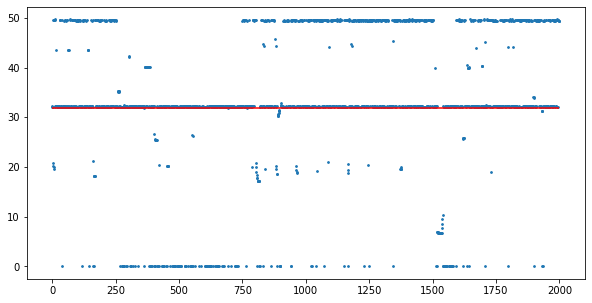

In [131]:
laser_id = theta_raw[6] == theta
azimuth_channel = np.around((29845/100)/0.2).astype('int')
plt.figure(figsize=(10,5))
plt.scatter(np.arange(2000),aggregated_maps_temp[:2000,laser_id,azimuth_channel], s = 3)
plt.hlines(threshold_map[laser_id,azimuth_channel],0,2000,color = 'r')
plt.show()

In [146]:
db = Raster_DBSCAN(window_size=(5,13),eps = 1.2, min_samples= 8, Td_map_szie=threshold_map.shape)   
Td_map = collector_0.aggregated_map[3]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_33')

In [144]:
db = Raster_DBSCAN(window_size=(5,13),eps = 1.2, min_samples= 8, Td_map_szie=threshold_map.shape)   
Td_map = collector_0.aggregated_map[444]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored_filtered(Td_map,Labeling_map,Foreground_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_31')

In [105]:
db = Raster_DBSCAN(window_size=(5,11),eps = 1.2, min_samples= 8, Td_map_szie=threshold_map.shape)   
Td_map = collector_0.aggregated_map[449]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored_filtered(Td_map,Labeling_map,Foreground_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_22')

In [59]:
#points_num,dir_vec[0],dir_vec[1],height,length,width,area

In [106]:
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
mea_init,app_init,unique_label_init,Labeling_map = extract_xy(Labeling_map,Td_map)

In [109]:
for i in range(440,450):
    Td_map = collector_0.aggregated_map[i]
    Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    mea_init,app_init,unique_label_init,Labeling_map = extract_xy(Labeling_map,Td_map)
    aa = mea_init[:,0,:][1]
    print(11111111111111111)
    print(aa)
    print(app_init[1])
    print(11111111111111111)

11111111111111111
[[-3.16584038]
 [ 5.85509929]]
[[40.        ]
 [ 0.85096675]
 [ 0.52521956]
 [ 0.5614742 ]
 [ 0.49167418]
 [ 0.23493883]
 [ 0.11551335]]
11111111111111111
11111111111111111
[[-3.13972266]
 [ 5.80679558]]
[[37.        ]
 [ 0.94609886]
 [ 0.3238779 ]
 [ 0.52325126]
 [ 0.46854839]
 [ 0.20873819]
 [ 0.09780394]]
11111111111111111
11111111111111111
[[-3.25294406]
 [ 5.63426439]]
[[38.        ]
 [ 0.96874774]
 [ 0.24804823]
 [ 0.55972496]
 [ 0.60295099]
 [ 0.19803393]
 [ 0.11940476]]
11111111111111111
11111111111111111
[[-3.1621488 ]
 [ 5.43311562]]
[[42.        ]
 [ 0.98237354]
 [ 0.18692841]
 [ 0.54326485]
 [ 0.57466346]
 [ 0.21806376]
 [ 0.12531327]]
11111111111111111
11111111111111111
[[-3.04494053]
 [ 5.27399171]]
[[40.        ]
 [ 0.90338159]
 [ 0.42883766]
 [ 0.53288094]
 [ 0.55340946]
 [ 0.22039677]
 [ 0.12196966]]
11111111111111111
11111111111111111
[[-2.91390865]
 [ 5.17135476]]
[[37.        ]
 [ 0.68691242]
 [ 0.72674024]
 [ 0.50632251]
 [ 0.52026373]
 [ 0.228784

In [100]:
mea_init,app_init,unique_label_init,Labeling_map = extract_xy(Labeling_map,Td_map)

In [2]:
bck_path = r'D:\LiDAR_Data\MidTown\Liberty\bck'
pcaps_list = os.listdir(bck_path)
pcaps_list = [p for p in pcaps_list if 'pcap' in p.split('.')]
aggregated_maps_multiple = []
for i in range(len(pcaps_list)):
    collector = RansacCollector(pcap_path=os.path.join(bck_path,pcaps_list[i]),output_file_path=bck_path,update_frame_num=3000)
    collector.gen_tdmap()
    aggregated_maps_multiple.append(collector.aggregated_map[np.random.choice(np.arange(0,3000),size = 1000 ,replace = False)])

Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:49<00:00, 27.27it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:49<00:00, 27.36it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:47<00:00, 27.93it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:45<00:00, 28.51it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:47<00:00, 27.80it/s]


In [3]:
aggregated_maps_multiple = np.concatenate(aggregated_maps_multiple,axis = 0)

In [10]:
d = 0.5
thred_s = 0.25
N = 20
delta_thred = 1e-3
step = 0.1
aggregated_maps_temp = aggregated_maps_multiple
threshold_map = np.zeros((32,1800))
print('Generating Threshold Map')
for i in range(32):
    for j in range(1800):
        t_s = aggregated_maps_temp[:,i,j].copy()
        threshold_value = get_thred_modified(t_s,d,thred_s,N,delta_thred,step)
        threshold_map[i,j] = threshold_value


Generating Threshold Map


In [37]:
np.save(r'D:\LiDAR_Data\MidTown\California\test_thred_map.npy',threshold_map)

In [11]:
collector_0 = RansacCollector(pcap_path=r'D:\LiDAR_Data\MidTown\Liberty\2021-12-10-12-20-23R.pcap',output_file_path='D:\LiDAR_Data\MidTown\Liberty',update_frame_num=2000)
collector_0.gen_tdmap()

Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.48it/s]


In [12]:
db = Raster_DBSCAN(window_size=(5,11),eps = 1.2, min_samples= 8, Td_map_szie=threshold_map.shape)   
Td_map = collector_0.aggregated_map[449]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored_filtered(Td_map,Labeling_map,Foreground_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_1')

In [17]:
d = 1
thred_s = 0.1
N = 30
delta_thred = 1e-3
step = 0.1
aggregated_maps_temp = collector.aggregated_map.copy()
threshold_map = np.zeros((32,1800))
print('Generating Threshold Map')
for i in range(32):
    for j in range(1800):
        t_s = aggregated_maps_temp[:,i,j].copy()
        threshold_value = get_thred(t_s,d,thred_s,N,delta_thred,step)
        threshold_map[i,j] = threshold_value
# collector.gen_thredmap(d = 1,thred_s = 0.2,N = 10,delta_thred = 1e-3,step = 0.1)
db = Raster_DBSCAN(window_size=(5,13),eps = 1.7, min_samples= 17, Td_map_szie=threshold_map.shape)   
Td_map = collector.aggregated_map[0]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored_filtered(Td_map,Labeling_map,Foreground_map)
draw(pcd,height=1000,width=1000)

Generating Threshold Map


WebVisualizer(window_uid='window_2')

In [155]:
collector = RansacCollector(pcap_path=r'D:\LiDAR_Data\US395.pcap',output_file_path='D:\LiDAR_Data',update_frame_num=17950)
lidar_reader = TDmapLoader(r'D:\LiDAR_Data\US395.pcap')
frame_gen = lidar_reader.frame_gen()
thred_map_list = []
aggregated_map_list = []
aggregated_maps = []

for i in tqdm_notebook(range(1,2000)):
    if i%2000 == 0:
        aggregated_maps = np.array(aggregated_maps)
        collector.aggregated_map  = aggregated_maps
        collector.gen_thredmap(d = 1,thred_s = 0.2,N = 10,delta_thred = 1e-3,step = 0.1)
        thred_map_list.append(collector.thred_map.copy())
        aggregated_map_list.append(aggregated_maps)
        aggregated_maps = []
        
    Td_map = next(frame_gen)
    aggregated_maps.append(Td_map)
    

C:\Users\zhChe\AppData\Local\Temp/ipykernel_13256/875614583.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1,2000)):


  0%|          | 0/1999 [00:00<?, ?it/s]

In [86]:
td_tc = []
db = Raster_DBSCAN(window_size=(5,15),eps = 1.5, min_samples= 10, Td_map_szie=threshold_map.shape)  
for i in tqdm_notebook(range(len(thred_map_list))):
    for j in range(len(aggregated_map_list[i])):
        Td_map = aggregated_map_list[i][j]
        thrlleshold_map = thred_map_list[i]
        Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
        a = time.perf_counter()
        Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
        td_tc.append((time.perf_counter() - a)*1000)

        

C:\Users\zhChe\AppData\Local\Temp/ipykernel_13256/829189533.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(thred_map_list))):


  0%|          | 0/8 [00:00<?, ?it/s]

In [97]:
db_tc = []
db_db = DBSCAN(eps = 1.5,min_samples = 15)
for i in tqdm_notebook(range(len(thred_map_list))):
    for j in range(len(aggregated_map_list[i])):
        Td_map = aggregated_map_list[i][j]
        threshold_map = thred_map_list[i]
        Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
        XYZ = cal_xyz_coords_db(Foreground_map,Td_map)
        a = time.perf_counter()
        Labels_db = db_db.fit_predict(XYZ)
        db_tc.append((time.perf_counter() - a)*1000)

C:\Users\zhChe\AppData\Local\Temp/ipykernel_13256/2806941928.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(thred_map_list))):


  0%|          | 0/8 [00:00<?, ?it/s]

In [99]:
from scipy.optimize import curve_fit
def func(x,b,c):
    return b*x*np.log(b*x) + c

In [89]:
def cal_xyz_coords_db(Foreground_map,Td_map):
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i] * np.pi / 180
        latitudes = azimuths[Foreground_map[i]] * np.pi / 180
        hypotenuses = td_freq_map[i][Foreground_map[i]] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i][Foreground_map[i]] * np.sin(longitudes)
        Xs.append(X)
        Ys.append(Y)
        Zs.append(Z)
    Xs = np.concatenate(Xs).reshape(-1,1)
    Ys = np.concatenate(Ys).reshape(-1,1)
    Zs = np.concatenate(Zs).reshape(-1,1)
    XYZ = np.concatenate([Xs,Ys,Zs],axis = 1)
    
    return XYZ

In [100]:
fore_ground_points_by_frame = []
for i in tqdm_notebook(range(len(thred_map_list))):
    for j in range(len(aggregated_map_list[i])):
        Td_map = aggregated_map_list[i][j]
        threshold_map = thred_map_list[i]
        Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
        fore_ground_points_by_frame.append(Foreground_map.sum())

C:\Users\zhChe\AppData\Local\Temp/ipykernel_13256/185354392.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(thred_map_list))):


  0%|          | 0/8 [00:00<?, ?it/s]

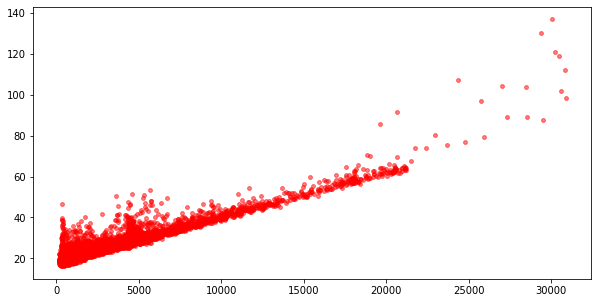

In [105]:
plt.figure(figsize=(10,5))
plt.scatter(fore_ground_points_by_frame,td_tc,s = 15, c = 'r',label = 'FSPC',alpha = 0.5)

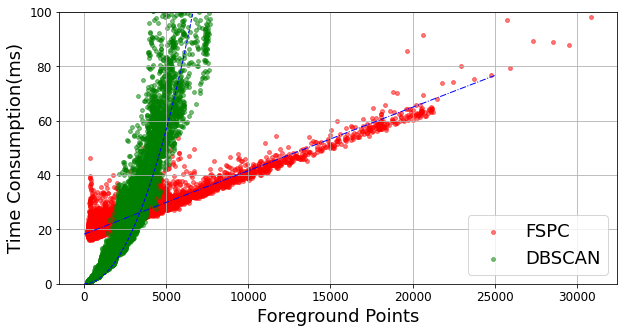

In [107]:
plt.figure(figsize=(10,5))
plt.scatter(fore_ground_points_by_frame,td_tc,s = 15, c = 'r',label = 'FSPC',alpha = 0.5)
plt.scatter(fore_ground_points_by_frame,db_tc,s = 15, c = 'g',label = 'DBSCAN',alpha = 0.5)
x = np.arange(25000)
a,b,c = np.polyfit(fore_ground_points_by_frame,db_tc,2)
y_db = a*x**2 + b
a,b = np.polyfit(fore_ground_points_by_frame,td_tc,1)
y_td = a*x + b
plt.plot(x,y_db,c = 'b',linewidth = 1, linestyle = 'dashed')
plt.plot(x,y_td,c = 'b',linewidth = 1, linestyle = '-.')
plt.grid()
plt.ylabel('Time Consumption(ms)',fontsize = 18)
plt.xlabel('Foreground Points',fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 18)
plt.ylim(0,100)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\Presentation\trb\4.tif',dpi = 300)
plt.show()